In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

import sys
sys.path.append('../')
from utils import *

In [2]:
watches = pd.read_pickle('../../data/user-level-data')
videos = pd.read_pickle('../../data/videos_raw_metadata')

In [ ]:
watches_df = dict()

def convert(watch):
    d = dict()
    d['playing'] = watch['playing']['id']
    suggested = []
    for s in watch['suggested']:
        if s != None:
            suggested.append(s['id'])
    d['suggested'] = suggested
    d['selected'] = watch['selected']
    return d

for user in watches:
    watches_df[user] = []
    for watch in watches[user]:
        if watch['playing'] == None:
            continue
        watch = convert(watch)
        watches_df[user].append(watch)

In [ ]:
history = dict()
users = list(watches_df.keys())
data = dict()

for user in users:
    if len(watches_df[user]) < 10:
        continue
    history[user] = watches_df[user][:10]

    for watch in watches_df[user][10:]:
        if watch['selected'] != None:
            if user not in data:
                data[user] = []
            data[user].append(watch)

for user in list(history.keys()):
    if user not in data:
        history.pop(user)

In [ ]:
for user in history:
    history[user] = [s['playing'] for s in history[user]]
    history[user] = [get_topic_vector(s) for s in history[user]]
    history[user] = np.array(history[user]).mean(axis=0)

In [ ]:
from collections import Counter


all_topics = []
all_tags = []

for video in videos:
    video = videos[video]
    
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    all_topics += topics
    
    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    all_tags += tags

all_topics = list(set(all_topics))

atc = Counter(all_tags)
atc = pd.DataFrame.from_dict(atc, 'index', columns=['count'])
atc = atc.sort_values(['count'], ascending=False).head(5000)
all_tags = list(atc.index)

def get_one_hot_vector(topics, tags):
    oh_topics = np.zeros(len(all_topics))
    for topic in topics:
        oh_topics[all_topics.index(topic)] = 1
        
    oh_tags = np.zeros(len(all_tags))
    for tag in tags:
        if tag in all_tags:
            oh_tags[all_tags.index(tag)] = 1
        
    oh = np.concatenate([oh_topics , oh_tags])
    
    return oh


def get_topic_vector(video):
    video = videos[video]
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    return get_one_hot_vector(topics, tags)


In [ ]:
X = []
Y = []

for user in tqdm(data):
    user_history = history[user]
    for watch in data[user]:
        
        playing = watch['playing']
        selected = watch['selected']
        upnext = watch['suggested'][:15]

        if playing not in videos or selected not in videos or any([s not in videos for s in watch['suggested']]):
            continue
        if len(watch['suggested']) < 15:
            continue


        playing = get_topic_vector(watch['playing'])


        
        for i, s in enumerate(upnext):
            selected = watch['selected']

            if s == selected:
                y = 1
            else:
                y = 0

            sv = get_topic_vector(s)

            sv = np.concatenate([sv, [i]])
            x = np.concatenate([user_history, playing, sv])

            X.append(x)
            Y.append(y)


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.5345587128726417, 1: 7.734065716547902}

In [7]:
X_train.shape

(187548, 15187)

In [18]:
# pkl.dump(X, open('temp-X', 'wb'))
# pkl.dump(Y, open('temp-Y', 'wb'))

In [ ]:
X = pkl.load((open('temp-X', 'rb')))
Y = pkl.load((open('temp-Y', 'rb')))

2023-08-08 12:58:00.102668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 12:58:00.620653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# train neural network

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD


model = Sequential()
model.add(Dense(5000, activation='relu', input_dim=15187))
model.add(Dropout(0.2))
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc'),       
           keras.metrics.AUC(name='prc', curve='PR')]
# import sgd

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=METRICS)


In [17]:
model.fit(X_train, y_train,
            epochs=10,
            batch_size=16, 
            class_weight=class_weights, validation_split=0.2)

Epoch 1/10
9378/9378 [==============================] - 122s 13ms/step - loss: 0.7005 - accuracy: 0.4088 - auc: 0.5955 - prc: 0.0935 - val_loss: 0.6808 - val_accuracy: 0.3189 - val_auc: 0.5661 - val_prc: 0.0729
Epoch 2/10
9378/9378 [==============================] - 115s 12ms/step - loss: 0.6776 - accuracy: 0.5872 - auc: 0.6142 - prc: 0.1142 - val_loss: 0.6617 - val_accuracy: 0.8749 - val_auc: 0.5234 - val_prc: 0.1253
Epoch 3/10
9378/9378 [==============================] - 118s 13ms/step - loss: 0.6449 - accuracy: 0.8388 - auc: 0.6512 - prc: 0.1368 - val_loss: 0.6211 - val_accuracy: 0.8812 - val_auc: 0.6374 - val_prc: 0.1372
Epoch 4/10
9378/9378 [==============================] - 116s 12ms/step - loss: 0.6478 - accuracy: 0.8861 - auc: 0.6329 - prc: 0.1440 - val_loss: 0.6648 - val_accuracy: 0.9038 - val_auc: 0.6104 - val_prc: 0.1359
Epoch 5/10
9378/9378 [==============================] - 118s 13ms/step - loss: 0.6527 - accuracy: 0.8978 - auc: 0.6081 - prc: 0.1392 - val_loss: 0.6312 - va

1466/1466 [==============================] - 4s 3ms/step


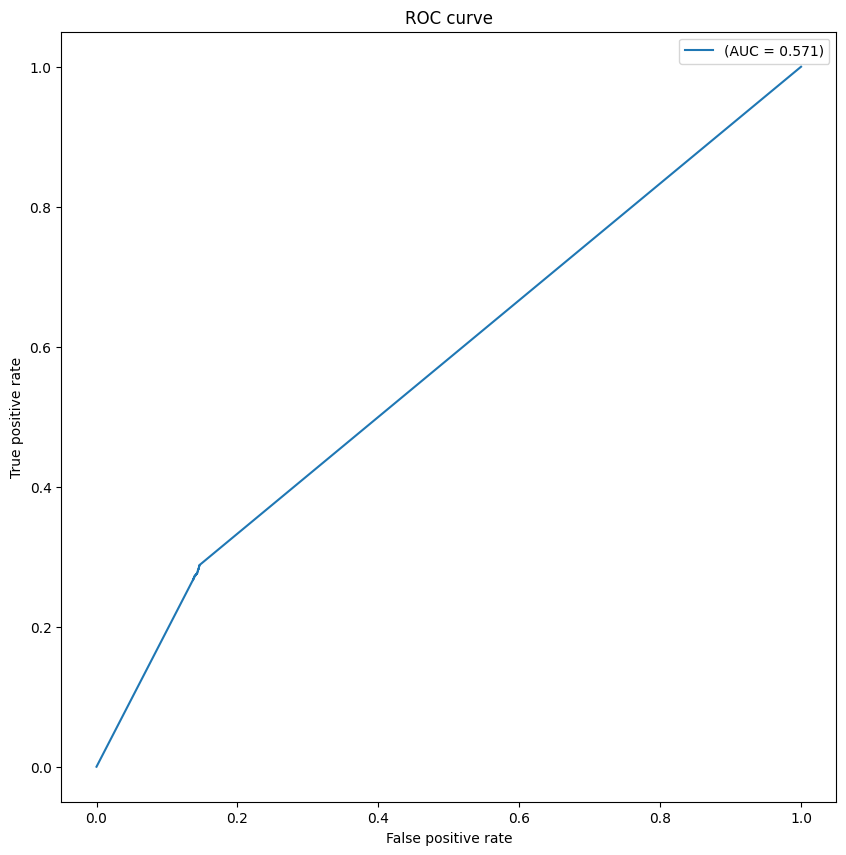

In [18]:
# plot auc curve for test

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)